In [15]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, uniform, kstest

In [17]:
# Function: computing W and d (diagonal entries)

def A_matrix(A_dim=100, W_tilde_mean=0, W_tilde_scale=1, exp_rate=1):
    
    # IID N(W_tilde_mean, W_tilde_scale) entries
    W_tilde = np.random.normal(loc = W_tilde_mean, 
                               scale = W_tilde_scale, 
                               size = (A_dim, A_dim))
    
    # QR decomposition
    Q, R = np.linalg.qr(W_tilde)
    W = Q

    # Diagonal matrix elements (using Exp(lambda))
    exp_scale = 1/exp_rate
    d = np.random.exponential(scale=exp_scale, size=A_dim)
    
    return W, d

In [19]:
# Function: drawing solution vectors x^(i) from prior mu_0 = N(0, A^-1)

def sample_solution_x(W, d):
    
    # Inverse & squareroot of D matrix elements for transforming std. normal samples
    inv_sqrt_d = 1.0 / np.sqrt(d)
    B = W @ np.diag(inv_sqrt_d)
    
    # Std. normal samples
    z = np.random.normal(size=(W.shape[0], 1))
    
    # Transform
    solution_x = B @ z
    
    return solution_x

In [21]:
# Function: Randomised Postiterations (Algorithm 1)

def rand_post_iter(A, b, x0, eps_1, eps_2, max_iter):
    
    # Initialisation
    k = 0
    k2 = 0 # For limiting number of post-iterations

    r = b - A @ x0
    r_list = [r]
    psi_list =[]
    v_list = []
    p = r.copy()
    p_list = [p]
    
    x = x0.copy()
    x_list = [x0]
    
    L = []
    appended_to_L = False
    x_solution = None
    
    # Loop to find x* with ||r|| <= eps_1
    while True:
        
        Ap = A @ p
        rTr = r.T @ r
        alpha = (rTr) / (p.T @ Ap)
        
        x_new = x + (alpha * p)
        x_list.append(x_new)

        r_new = r - (alpha * Ap)
#         r_list.append(r_new)
        # r_new = b - A @ x_new
        
        beta = (r_new.T @ r_new) / rTr
        
        p_new = r_new # + beta * p
        
        for p_i in p_list:
            p_new = p_new - (p_new.T @ A @ p_i)/(p_i.T @ A @ p_i) * p_i
        
        p_list.append(p_new)
        
        if (x_solution is None) and (np.linalg.norm(r_new) <= eps_1):
            
            x_solution = x_new.copy()
#             print(f"Converged: less than eps_1 at iteration {k}")
        
        if (x_solution is not None) and (np.linalg.norm(r_new) > eps_2):
            psi = alpha.copy()
            psi_list.append(psi)
            # print("Alpha = ", alpha, "at K = ", k)
            # print("Psi = ", psi)

            # Normalising term for search directions if needed (not used)
            vIP = p.T @ A @ p
            v_list.append(p / np.sqrt(vIP))
            
            L.append(psi * p)
            # print("k2 = ", k2)           

            k2 += 1
            appended_to_L = True

        if k2 == max_iter:
#             print("Hit maximum iterations")
            break
            
        elif (np.linalg.norm(r_new) <= eps_2):
#             print(f"Converged: less than eps_2 at iteration {k}")
            break
        
        x = x_new.copy()
        r = r_new.copy()
        p = p_new.copy()
        k += 1
        
    if not appended_to_L:
#        print("No directions added to L")
        psi = alpha 
        L.append(psi * p)
    
    
    L_matrix = np.column_stack(L)
#     print("L dimensions:", L_matrix.shape)
    P_m = np.hstack(p_list[-k2:])
    V_m = np.hstack(v_list)
    
    z = np.random.normal(1, psi_list).reshape(-1, 1)
    x_solution += P_m @ z
    
    return x_solution, L_matrix

In [23]:
def sim_based_cal( 
    x0, 
    eps_1, 
    eps_2,
    max_iter,
    A_dim = 100, 
    W_tilde_mean = 0, 
    W_tilde_scale = 1, 
    exp_rate = 1,
    n_sim = 1
):
    t = []
    
    # Fixed random vector
    w = np.random.normal(loc = 0, scale=1, size=A_dim)
    
    # Computing fixed A/W/d for entire experiment
    W, d = A_matrix(A_dim, W_tilde_mean, W_tilde_scale, exp_rate)
    A = W @ np.diag(d) @ W.T
    
    for i in range(n_sim):
        
        # Sampled solution
        x_star = sample_solution_x(W, d)
        b = A @ x_star
        
        x_solution, L = rand_post_iter(A, b, x0, eps_1, eps_2, max_iter)
        numerator = w.T @ (x_solution - x_star)
        denominator = np.sqrt(w.T @ L @ L.T @ w)
        # print(numerator)
        # print(denominator)
        cdf = norm.cdf(numerator/denominator)
        t.append(cdf)
 
    t_vector = np.array(t)
    
    return t_vector

**Example**

In [26]:
np.random.seed(204)

t_values = sim_based_cal( 
        x0 = np.zeros((100,1)), 
        eps_1 = 1e-3,
        eps_2 = 1e-12,
        max_iter = 10,
        A_dim = 100, 
        W_tilde_mean = 0, 
        W_tilde_scale = 1, 
        exp_rate = 1,
        n_sim = 1000
);

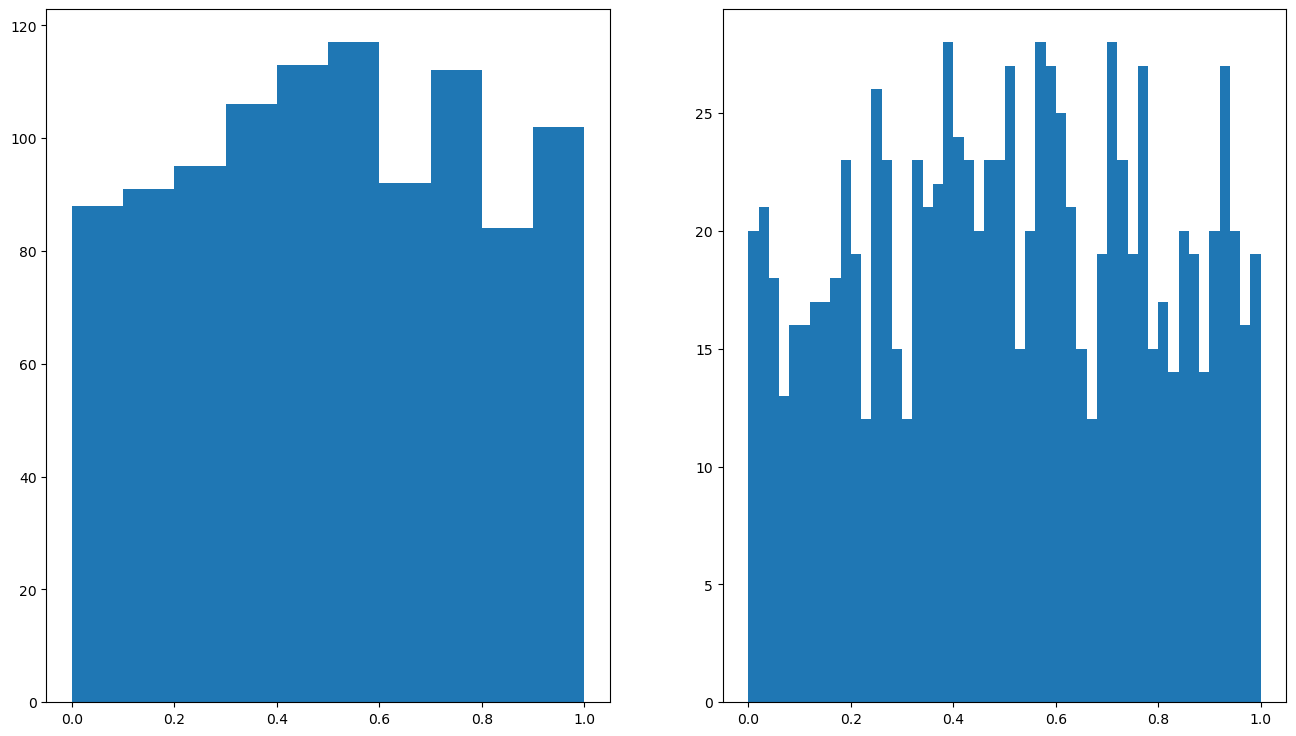

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.hist(t_values, 10)
ax2.hist(t_values, 50);